In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, make_scorer

from skopt import BayesSearchCV
import optuna
import os


f1_macro_scorer = make_scorer(f1_score, average='macro')

def load_and_split_data():
    """Load prepared X and y data and split into train/test sets."""
    x_path = r"C:\Users\sharg\Desktop\uyga vazifa\unsupervised learning\4-oy\6-project\binance.com\data\final_training_data\X_balanced.csv"
    y_path = r"C:\Users\sharg\Desktop\uyga vazifa\unsupervised learning\4-oy\6-project\binance.com\data\final_training_data\y_balanced.csv"

    # Load data
    X = pd.read_csv(x_path)
    y = pd.read_csv(y_path).squeeze()  

    # Check shapes
    print(f"Loaded X shape: {X.shape}")
    print(f"Loaded y shape: {y.shape}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Data successfully split into train and test sets.")
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_and_split_data()


Loaded X shape: (10185, 13)
Loaded y shape: (10185,)
Data successfully split into train and test sets.


In [2]:
# Block 1: Grid Search (GridSearchCV)
print("--- 1. Grid Search (GridSearchCV) ---")
start_time = time.time()

# Define a relatively small, focused parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=f1_macro_scorer, # Objective: Maximize F1 Macro
    cv=3, # Low CV for quicker execution
    verbose=1,
    n_jobs=-1 # Use all available cores
)

# Perform the search
grid_search.fit(X_train, y_train)

# Output results
print("\nBest parameters found on training set:")
print(grid_search.best_params_)
best_rf_grid = grid_search.best_estimator_
y_pred_grid = best_rf_grid.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_grid):.4f}")
print(f"Test F1 Macro: {f1_score(y_test, y_pred_grid, average='macro'):.4f}")
print(f"Time taken: {time.time() - start_time:.2f} seconds\n")

--- 1. Grid Search (GridSearchCV) ---
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters found on training set:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.4247
Test F1 Macro: 0.4220
Time taken: 17.61 seconds



In [3]:
# Block 2: Random Search (RandomizedSearchCV)
print("--- 2. Random Search (RandomizedSearchCV) ---")
start_time = time.time()

# Define the parameter distribution (wider range is possible)
param_dist = {
    'n_estimators': np.arange(50, 301, 50), # 50 to 300
    'max_depth': np.arange(5, 31),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 6),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Initialize RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50, # Number of parameter settings that are sampled
    scoring=f1_macro_scorer,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform the search
random_search.fit(X_train, y_train)

# Output results
print("\nBest parameters found on training set:")
print(random_search.best_params_)
best_rf_random = random_search.best_estimator_
y_pred_random = best_rf_random.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_random):.4f}")
print(f"Test F1 Macro: {f1_score(y_test, y_pred_random, average='macro'):.4f}")
print(f"Time taken: {time.time() - start_time:.2f} seconds\n")

--- 2. Random Search (RandomizedSearchCV) ---
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found on training set:
{'n_estimators': np.int64(300), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(2), 'max_depth': np.int64(26), 'criterion': 'gini', 'bootstrap': False}
Test Accuracy: 0.4238
Test F1 Macro: 0.4226
Time taken: 33.25 seconds



In [4]:
# Block 3: Bayesian Optimization (BayesSearchCV from scikit-optimize)
print("--- 3. Bayesian Optimization (BayesSearchCV) ---")
start_time = time.time()

# Define the search space using skopt space objects
from skopt.space import Integer, Categorical
search_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'criterion': Categorical(['gini', 'entropy'])
}

# Initialize BayesSearchCV
rf = RandomForestClassifier(random_state=42)
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=search_space,
    n_iter=30, # Fewer iterations than Random Search are usually needed
    scoring=f1_macro_scorer,
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Perform the search
bayes_search.fit(X_train, y_train)

# Output results
print("\nBest parameters found on training set:")
print(bayes_search.best_params_)
best_rf_bayes = bayes_search.best_estimator_
y_pred_bayes = best_rf_bayes.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_bayes):.4f}")
print(f"Test F1 Macro: {f1_score(y_test, y_pred_bayes, average='macro'):.4f}")
print(f"Time taken: {time.time() - start_time:.2f} seconds\n")

--- 3. Bayesian Optimization (BayesSearchCV) ---

Best parameters found on training set:
OrderedDict({'criterion': 'entropy', 'max_depth': 26, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300})
Test Accuracy: 0.4336
Test F1 Macro: 0.4310
Time taken: 81.12 seconds



In [5]:
# Block 4: Optuna (Tuning Framework)
print("--- 4. Optuna ---")
start_time = time.time()

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to search using Optuna's suggestion methods
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    # Train the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
        n_jobs=-1
    )
    
    # Evaluate the model using cross-validation
    score = cross_val_score(model, X_train, y_train, cv=3, scoring=f1_macro_scorer).mean()
    # Optuna is set to 'maximize' the returned score
    return score

# Create a study object and optimize the objective function
# Using TPE sampler for efficient search
study = optuna.create_study(direction='maximize', study_name='rf_tuning_optuna', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Output results
print("\nBest parameters found on training set:")
print(study.best_params)
# Train the final model with the best parameters found
best_rf_optuna = RandomForestClassifier(**study.best_params, random_state=42)
best_rf_optuna.fit(X_train, y_train)
y_pred_optuna = best_rf_optuna.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_optuna):.4f}")
print(f"Test F1 Macro: {f1_score(y_test, y_pred_optuna, average='macro'):.4f}")
print(f"Time taken: {time.time() - start_time:.2f} seconds\n")

[I 2025-11-03 20:23:29,071] A new study created in memory with name: rf_tuning_optuna


--- 4. Optuna ---


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-03 20:23:29,713] Trial 0 finished with value: 0.4111591833158859 and parameters: {'n_estimators': 144, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.4111591833158859.
[I 2025-11-03 20:23:30,130] Trial 1 finished with value: 0.4054564456689671 and parameters: {'n_estimators': 64, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.4111591833158859.
[I 2025-11-03 20:23:31,253] Trial 2 finished with value: 0.38943025762041844 and parameters: {'n_estimators': 258, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 0 with value: 0.4111591833158859.
[I 2025-11-03 20:23:32,021] Trial 3 finished with value: 0.39644326108461186 and parameters: {'n_estimators': 158, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 0 with value: 0.4111591833158859

In [6]:
# Block 5: Manual Iterative Fine-Tuning (Focusing on the top 2 parameters)
print("--- 5. Manual Iterative Fine-Tuning ---")
start_time = time.time()

# Define specific values for the two most impactful parameters
n_estimators_list = [100, 150, 200, 250]
max_depth_list = [15, 20, 25]

best_score = 0
best_params_manual = {}
results_list = []

# Loop through a predefined set of fixed combinations
for n_est in n_estimators_list:
    for depth in max_depth_list:
        # Initialize model with current params and other fixed good params
        model = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_split=5, # Fixed based on common practices
            criterion='gini',    # Fixed based on common practices
            random_state=42
        )
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=f1_macro_scorer, n_jobs=-1)
        mean_score = cv_scores.mean()
        
        results_list.append({
            'n_estimators': n_est,
            'max_depth': depth,
            'F1_Macro_CV': mean_score
        })
        
        # Track the best model
        if mean_score > best_score:
            best_score = mean_score
            best_params_manual = {'n_estimators': n_est, 'max_depth': depth}

# Output results
results_df = pd.DataFrame(results_list)
print("\nManual Tuning Results (Top 5):")
print(results_df.sort_values(by='F1_Macro_CV', ascending=False).head())

best_rf_manual = RandomForestClassifier(
    **best_params_manual, 
    min_samples_split=5, 
    criterion='gini', 
    random_state=42
)
best_rf_manual.fit(X_train, y_train)
y_pred_manual = best_rf_manual.predict(X_test)
print("\nBest parameters used for final model:")
print(best_params_manual)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_manual):.4f}")
print(f"Test F1 Macro: {f1_score(y_test, y_pred_manual, average='macro'):.4f}")
print(f"Time taken: {time.time() - start_time:.2f} seconds\n")

--- 5. Manual Iterative Fine-Tuning ---

Manual Tuning Results (Top 5):
    n_estimators  max_depth  F1_Macro_CV
8            200         25     0.414398
7            200         20     0.413537
4            150         20     0.413353
5            150         25     0.413258
10           250         20     0.413218

Best parameters used for final model:
{'n_estimators': 200, 'max_depth': 25}
Test Accuracy: 0.4431
Test F1 Macro: 0.4404
Time taken: 24.46 seconds



✅ Data loaded successfully:
X_train: (7129, 13), X_test: (3056, 13)

--- Model Comparison on Test Set ---
Grid Search RF: Accuracy=0.4247, F1 Macro=0.4220
Random Search RF: Accuracy=0.4238, F1 Macro=0.4226
Bayesian Opt. RF: Accuracy=0.4336, F1 Macro=0.4310
Optuna RF: Accuracy=0.4247, F1 Macro=0.4214
Manual Fine-Tune RF: Accuracy=0.4267, F1 Macro=0.4242

FINAL TUNING COMPARISON RESULTS
                 Model  Accuracy  F1 Macro
0     Bayesian Opt. RF  0.433573  0.431049
1  Manual Fine-Tune RF  0.426702  0.424244
2     Random Search RF  0.423757  0.422597
3       Grid Search RF  0.424738  0.421967
4            Optuna RF  0.424738  0.421362

🏆 Overall Best Model: Bayesian Opt. RF
Test F1 Macro Score: 0.4310

✅ SUCCESS: The best model ('Bayesian Opt. RF') has been saved at:
C:\Users\sharg\Desktop\uyga vazifa\unsupervised learning\4-oy\6-project\binance.com\modeling\best_random_forest_model.joblib
📊 Model comparison results saved to:
C:\Users\sharg\Desktop\uyga vazifa\unsupervised learning\

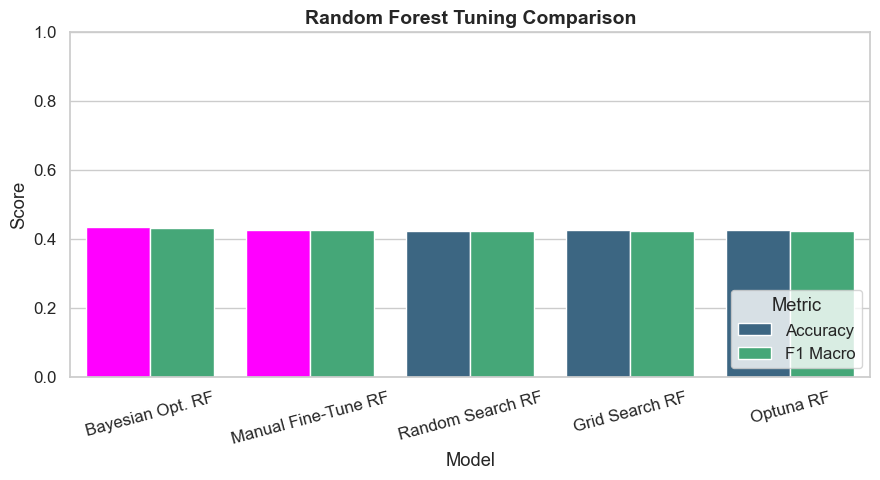

📈 Visualization saved as:
C:\Users\sharg\Desktop\uyga vazifa\unsupervised learning\4-oy\6-project\binance.com\modeling\comparison_plot.png


In [10]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

# --- 1. DATA LOADING FUNCTION ---

def load_and_split_data():
    """Loads feature and target data and performs a train-test split."""
    X_file = r"C:\Users\sharg\Desktop\uyga vazifa\unsupervised learning\4-oy\6-project\binance.com\data\final_training_data\X_balanced.csv"
    y_file = r"C:\Users\sharg\Desktop\uyga vazifa\unsupervised learning\4-oy\6-project\binance.com\data\final_training_data\y_balanced.csv"

    if not os.path.exists(X_file) or not os.path.exists(y_file):
        raise FileNotFoundError("❌ Data files not found. Please check the paths.")

    X = pd.read_csv(X_file)
    y = pd.read_csv(y_file).iloc[:, 0]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print(f"✅ Data loaded successfully:\nX_train: {X_train.shape}, X_test: {X_test.shape}")
    return X_train, X_test, y_train, y_test


# --- 2. LOAD DATA ---
X_train, X_test, y_train, y_test = load_and_split_data()


# --- 3. DEFINE BEST MODELS (using your real tuning outputs) ---

best_params_grid = { 
    'criterion': 'entropy',
    'max_depth': None,
    'min_samples_split': 2,
    'n_estimators': 200
}

best_params_random = {
    'n_estimators': 300,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_depth': 26,
    'criterion': 'gini',
    'bootstrap': False
}

best_params_bayes = {
    'criterion': 'entropy',
    'max_depth': 26,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 300
}

best_params_optuna = {
    'n_estimators': 143,
    'max_depth': 25,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'criterion': 'gini'
}

best_params_manual = {
    'n_estimators': 200,
    'max_depth': 25
}


# --- 4. TRAIN, PREDICT, AND COMPARE ALL BEST MODELS ---

models_to_compare = {
    'Grid Search RF': RandomForestClassifier(**best_params_grid, random_state=42),
    'Random Search RF': RandomForestClassifier(**best_params_random, random_state=42),
    'Bayesian Opt. RF': RandomForestClassifier(**best_params_bayes, random_state=42),
    'Optuna RF': RandomForestClassifier(**best_params_optuna, random_state=42),
    'Manual Fine-Tune RF': RandomForestClassifier(**best_params_manual, random_state=42)
}

results = []
best_f1_macro = -1
overall_best_model_name = ""
overall_best_model = None

print("\n--- Model Comparison on Test Set ---")
for name, model in models_to_compare.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1_mac = f1_score(y_test, y_pred, average='macro')
    
    results.append({'Model': name, 'Accuracy': acc, 'F1 Macro': f1_mac})
    print(f"{name}: Accuracy={acc:.4f}, F1 Macro={f1_mac:.4f}")
    
    if f1_mac > best_f1_macro:
        best_f1_macro = f1_mac
        overall_best_model_name = name
        overall_best_model = model


# --- 5. FINAL RESULTS, SAVE MODEL, AND VISUALIZE ---

results_df = pd.DataFrame(results).sort_values(by='F1 Macro', ascending=False).reset_index(drop=True)
print("\n" + "="*50)
print("FINAL TUNING COMPARISON RESULTS")
print("="*50)
print(results_df)

print(f"\n🏆 Overall Best Model: {overall_best_model_name}")
print(f"Test F1 Macro Score: {best_f1_macro:.4f}")

# Save best model
save_dir = r"C:\Users\sharg\Desktop\uyga vazifa\unsupervised learning\4-oy\6-project\binance.com\modeling"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "best_random_forest_model.joblib")
joblib.dump(overall_best_model, save_path)
print(f"\n✅ SUCCESS: The best model ('{overall_best_model_name}') has been saved at:\n{save_path}")

# Save comparison results as CSV
results_csv_path = os.path.join(save_dir, "model_comparison_results.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"📊 Model comparison results saved to:\n{results_csv_path}")

# --- Visualization ---

plt.figure(figsize=(9, 5))
sns.set(style="whitegrid", font_scale=1.1)

# Melt for grouped barplot
results_melted = results_df.melt(id_vars="Model", value_vars=["Accuracy", "F1 Macro"],
                                 var_name="Metric", value_name="Score")

ax = sns.barplot(data=results_melted, x="Model", y="Score", hue="Metric", palette="viridis")

# Highlight best model bars in magenta
best_model_idx = results_df[results_df["Model"] == overall_best_model_name].index[0]
ax.patches[best_model_idx * 2].set_facecolor("magenta")      # Accuracy bar
ax.patches[best_model_idx * 2 + 1].set_facecolor("magenta")  # F1 Macro bar

plt.title("Random Forest Tuning Comparison", fontsize=14, weight="bold")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.ylim(0, 1.0)
plt.legend(title="Metric", loc="lower right")
plt.tight_layout()

# Save the figure
plot_path = os.path.join(save_dir, "comparison_plot.png")
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"📈 Visualization saved as:\n{plot_path}")
